In [2]:
!pip install transformers
!pip install sentencepiece
!pip install nltk
!pip install ipywidgets

  Using cached transformers-4.15.0-py3-none-any.whl (3.4 MB)
  Using cached regex-2021.11.10-cp36-cp36m-manylinux_2_17_x86_64.manylinux2014_x86_64.whl (748 kB)
  Using cached filelock-3.4.1-py3-none-any.whl (9.9 kB)
  Using cached huggingface_hub-0.2.1-py3-none-any.whl (61 kB)
  Using cached tokenizers-0.10.3-cp36-cp36m-manylinux_2_5_x86_64.manylinux1_x86_64.manylinux_2_12_x86_64.manylinux2010_x86_64.whl (3.3 MB)
  Using cached sacremoses-0.0.46-py3-none-any.whl (895 kB)
  Using cached sentencepiece-0.1.96-cp36-cp36m-manylinux_2_17_x86_64.manylinux2014_x86_64.whl (1.2 MB)
  Using cached nltk-3.6.7-py3-none-any.whl (1.5 MB)
  Using cached ipywidgets-7.6.5-py2.py3-none-any.whl (121 kB)
  Using cached jupyterlab_widgets-1.0.2-py3-none-any.whl (243 kB)
  Using cached nbformat-5.1.3-py3-none-any.whl (178 kB)
  Using cached widgetsnbextension-3.5.2-py2.py3-none-any.whl (1.6 MB)
  Using cached jedi-0.17.2-py2.py3-none-any.whl (1.4 MB)
  Using cached parso-0.7.1-py2.py3-none-any.whl (109 kB)
 

In [3]:
import pandas as pd
import numpy as np
import random
import joblib
import torch

from sklearn import preprocessing
from sklearn import model_selection
# from DataAugmentation 
# from DataAugmentation import DataAugmentation
from transformers import AdamW
from transformers import get_linear_schedule_with_warmup
from importlib import reload
import config
from transformers import XLMRobertaForTokenClassification, XLMRobertaConfig ,BertModel, XLMRobertaTokenizer, XLMRobertaModel, BertForTokenClassification
from data_utils import loadDatafromFile,createTokenizedDf,CompDataset,createkfoldData,createDataloaders
from seqeval.metrics import accuracy_score, classification_report,f1_score
from sklearn.metrics import matthews_corrcoef,classification_report
import engine
# from model_new import EntityModel
import torch.nn as nn
from tqdm import tqdm

  Using cached seqeval-1.2.2-py3-none-any.whl


In [4]:
# Read the data
def process_data(filePath_src,filePath_tar, filePath_srcTags,filePath_tarTags,model_type):
    
    dataObj = loadDatafromFile(filePath_src,filePath_tar, filePath_srcTags,filePath_tarTags)
    df= dataObj.createDf() # get dataframe from files
    obj_tokenized = createTokenizedDf(df,model_type)
    df_new= obj_tokenized.convertDf()
#     enc_label = preprocessing.LabelEncoder()
#     df_new['labels']= enc_label.fit_transform(df_new['labels'])
    train_data = CompDataset(df_new,model_type)
    return train_data


In [5]:
# if loading of the non augmented (noise-free) data is needed, then run this
dataset_train = process_data(config.filePath_src,config.filePath_tar, config.filePath_srcTags,config.filePath_tarTags,model_type = 'xlm')
len(dataset_train)

7000

In [6]:
#loading dev/eval data
dataset_eval = process_data(config.filePath_src_eval,config.filePath_tar_eval, config.filePath_srcTags_eval,config.filePath_tarTags_eval,model_type = 'xlm')
len(dataset_eval)

1000

In [7]:
dataset_train[0]

(tensor([     0,  17151,  12426,   2765,    113,    527, 110896,  36997,     71,
          20387,   2189,    141,     99, 183124,     23,  58020,      6,      5,
              2,      2,    656,  58020,    656, 138438,     13,    656,  17151,
            656,  12426,   2765,    656,    113,    656,    527, 110896,    656,
          20387,   2189,    141,    656,     23,    656, 183124,    656,      6,
              5,    656,      2,      1,      1,      1,      1,      1,      1,
              1,      1,      1,      1,      1,      1,      1,      1,      1,
              1,      1,      1,      1,      1,      1,      1,      1,      1,
              1,      1,      1,      1,      1,      1,      1,      1,      1,
              1,      1,      1,      1,      1,      1,      1,      1,      1,
              1,      1,      1,      1,      1,      1,      1,      1,      1,
              1,      1,      1,      1,      1,      1,      1,      1,      1,
              1,      1,    

In [9]:
dataObj = loadDatafromFile(config.filePath_src,config.filePath_tar, config.filePath_srcTags,config.filePath_tarTags)
df= dataObj.createDf() 
df
# list(df.source)

,source,target,src_tokens,tar_tokens
0,José Ortega y Gasset visited Husserl at Freibu...,1934 besuchte José Ortega y Gasset Husserl in ...,OK OK OK OK OK OK OK OK OK OK OK,OK OK OK OK OK OK OK OK OK OK OK OK OK OK OK O...
1,"However , a disappointing ninth in China meant...",Eine enttäuschende Neunte in China bedeutete j...,OK OK OK BAD OK OK OK OK OK OK OK OK OK OK OK ...,OK BAD OK BAD OK BAD OK OK OK OK OK OK OK OK O...
2,"In his diary , Chase wrote that the release of...","In seinem Tagebuch , Chase schrieb , dass die ...",OK OK OK OK BAD BAD OK OK OK OK OK OK OK OK BA...,OK OK OK OK OK OK OK OK OK BAD OK BAD OK OK OK...
3,Heavy arquebuses mounted on wagons were called...,Schwere Arquebuses auf Waggons montiert wurden...,OK BAD BAD OK OK OK OK OK OK OK OK,OK OK OK BAD OK OK OK OK BAD BAD OK OK OK OK O...
4,Once North Pacific salmon die off after spawni...,Sobald der nordpazifische Lachs nach dem Laich...,OK OK OK OK BAD OK OK OK OK OK BAD OK BAD OK O...,OK OK OK BAD OK OK OK BAD OK OK OK OK OK OK OK...
...,...,...,...,...
6995,Some may also discourage or disallow unsanitar...,Einige können auch unhygienische Praktiken wie...,OK OK OK OK OK OK OK OK OK OK OK OK OK OK OK O...,OK OK OK OK OK OK OK OK OK OK OK OK OK OK OK O...
6996,"In the late 1860s , the crinolines disappeared...",In den späten 1860er Jahren verschwanden die K...,OK OK OK OK OK OK OK OK OK OK BAD BAD OK OK OK...,OK OK OK OK OK OK OK OK OK OK OK OK OK OK OK O...
6997,"Disco was criticized as mindless , consumerist...","Disco wurde als geistlos , konsumistisch , übe...",OK OK OK OK BAD OK BAD OK OK OK OK OK,OK OK OK OK OK OK OK BAD OK OK OK BAD OK OK OK...
6998,Planters would then fill large hogsheads with ...,Die Pflanzer würden dann große Heuschrecken mi...,OK OK OK BAD OK BAD OK OK BAD BAD OK OK OK OK OK,OK OK OK OK OK BAD OK OK OK OK OK BAD OK OK OK...


In [30]:
reload(DataAugmentation)
from DataAugmentation import DataAugmentation

In [10]:
dataaug_obj = DataAugmentation(df,swap_words=2,syn_words=2,del_words_prob=0.2,num_sentences=10)  
swapDataset = dataaug_obj.random_swap()
del_augDataset = dataaug_obj.random_deletion()
del_augDataset = del_augDataset[7000:]
syn_dataset = dataaug_obj.synonym_replacement()
syn_dataset = syn_dataset[7000:]
frames = [swapDataset , del_augDataset,syn_dataset]
aug_df  = pd.concat(frames)
aug_df

,source,target,src_tokens,tar_tokens
0,José Ortega y Gasset visited Husserl at Freibu...,1934 besuchte José Ortega y Gasset Husserl in ...,OK OK OK OK BAD OK OK OK BAD BAD OK,OK BAD OK BAD OK OK OK OK OK OK OK OK BAD OK O...
1,"however , a disappointing ninth in China meant...",eine enttäuschende Neunte in China bedeutete j...,OK BAD BAD BAD BAD OK OK OK OK OK OK OK OK OK ...,BAD BAD OK BAD OK BAD OK OK OK OK OK OK OK OK ...
2,"in his diary , Chase wrote that the release of...","in seinem Tagebuch , Chase schrieb , dass die ...",OK OK OK OK OK BAD OK OK BAD OK OK BAD OK BAD ...,OK OK OK OK OK OK OK BAD OK OK OK BAD OK OK OK...
3,Heavy arquebuses mounted on wagons were called...,schwere Arquebuses auf Waggons montiert wurden...,BAD BAD OK OK BAD BAD BAD OK OK OK OK,OK OK BAD BAD OK OK OK BAD OK OK BAD OK BAD OK...
4,once North Pacific salmon die off after spawni...,sobald der nordpazifische Lachs nach dem Laich...,OK OK OK OK OK OK OK BAD OK BAD BAD BAD BAD OK...,OK OK OK OK OK OK OK OK OK OK OK OK OK OK BAD ...
...,...,...,...,...
76995,"he mass Krishna 's most grave enemy , Jarasand...",er tötete Krishnas gefährlichsten Feind Jarasa...,OK BAD OK OK OK OK OK OK OK OK OK BAD BAD OK O...,OK OK OK BAD OK OK OK OK OK OK OK OK OK OK OK ...
76996,he great deal Krishna 's most dangerous enemy ...,er tötete Krishnas gefährlichsten Feind Jarasa...,OK BAD BAD OK OK OK OK OK OK OK OK OK BAD BAD ...,OK OK OK BAD OK OK OK OK OK OK OK OK OK OK OK ...
76997,"he slew Krishna 's most dangerous enemy , Jara...",er tötete Krishnas gefährlichsten Feind Jarasa...,OK BAD OK OK OK OK OK OK OK OK OK BAD BAD OK O...,OK OK OK BAD OK OK OK OK OK OK OK OK OK OK OK ...
76998,"he slue Krishna 's most dangerous enemy , Jara...",er tötete Krishnas gefährlichsten Feind Jarasa...,OK BAD OK OK OK OK OK OK OK OK OK BAD BAD OK O...,OK OK OK BAD OK OK OK OK OK OK OK OK OK OK OK ...


In [11]:
aug_df =aug_df.sample(frac=1).reset_index(drop=True)
aug_df

,source,target,src_tokens,tar_tokens
0,"Germany invaded France , , Luxembourg and the ...",Deutschland marschierte am 10. Mai 1940 in Fra...,OK OK OK OK OK OK OK BAD BAD OK OK OK,OK OK OK OK OK OK OK OK OK OK OK OK OK OK OK O...
1,the enzyme chitinase grow in the stomach helps...,das im Magen produzierte Enzym Chitinase hilft...,OK OK OK OK OK BAD OK BAD BAD BAD BAD BAD BAD ...,OK OK OK OK OK OK OK OK OK OK OK OK OK OK BAD ...
2,"Roger Rousseau , The French Foreign Legion in ...","Roger Rousseau , Die französische Fremdenlegio...",OK OK OK BAD OK BAD BAD OK OK OK OK OK,OK OK OK OK OK OK OK BAD OK OK BAD BAD OK OK O...
3,"in 1927 , Lieutenant Jaime Sabater , from San ...",1927 absolvierte Lieutenant Jaime Sabater aus ...,BAD OK OK BAD OK OK OK OK OK OK OK OK OK OK OK...,BAD OK OK OK OK BAD OK OK OK OK OK OK OK OK OK...
4,blackmails Sharon into meeting him at a motel,"Cameron erpresst Sharon , ihn in einem Motel z...",BAD BAD BAD OK OK OK OK OK,OK OK OK BAD OK OK BAD OK OK OK OK OK OK OK OK...
...,...,...,...,...
216995,maxilla baleen exclusively the in the sit jaw ...,die Zähne oder Baleen im Oberkiefer sitzen aus...,OK OK OK OK BAD OK OK OK OK OK OK OK OK OK,OK OK OK OK OK OK OK BAD OK OK OK OK OK OK OK ...
216996,the with clock with mainspring either 's motor...,die Hauptfeder der elektrischen Uhr wird entwe...,OK OK OK OK OK OK OK OK OK OK OK BAD OK OK OK ...,OK OK OK OK OK OK OK OK OK OK OK OK OK OK OK O...
216997,he accidentally frivol away Jane during an alt...,er schießt Jane versehentlich während einer Au...,OK OK BAD BAD OK OK OK OK OK OK OK OK OK OK OK...,OK OK OK BAD OK OK OK OK OK OK OK OK OK OK OK ...
216998,"Paul Collier disability advocate , Australian ...","Paul Collier , 46 , australischer Behindertena...",OK OK BAD BAD OK OK OK OK OK OK OK OK,OK OK OK OK OK OK OK OK OK OK OK OK BAD BAD OK...


In [12]:
# #DataAugmentation methods
# def random_swap(dataframe,n): # n is number of times to swap randomly 2 words
    
#     source_sentences  = list(dataframe.source)
#     target_sentences = list(dataframe.target)
#     labels_src = list(dataframe.src_tokens)
#     labels_tar = list(dataframe.tar_tokens)
#     source_sentences_temp =[]
#     labels_sec_temp=[]
#     i=0
    
#     for sentences, labels in zip(source_sentences,labels_src):
        
#         sentences = sentences.split()
#         labels = labels.split()
        
#         for _ in range(5):
#             for _ in range(n):
#                 sentences, labels = swap_word(sentences,labels)
#             assert(len(sentences) == len(labels))
#             sentences_str = ' '.join(sentences)
#             labels_str = ' '.join(labels)
#             target_sentences.append(target_sentences[i])
#             labels_tar.append(labels_tar[i])
#             source_sentences_temp.append(sentences_str)
#             labels_sec_temp.append(labels_str)
        
# #         break
#         i+=1
    
#     source_sentences.extend(source_sentences_temp)
#     labels_src.extend(labels_sec_temp)
# #     print(source_sentences)
# #     print(labels_src)
#     column_names = ["source","target","src_tokens","tar_tokens"]
#     df = pd.DataFrame(columns=column_names,dtype=object)
#     df = df.assign(source=source_sentences)
#     df = df.assign(target = target_sentences)
#     df = df.assign(src_tokens = labels_src)
#     df = df.assign(tar_tokens = labels_tar)
    
#     return df

# def swap_word(new_words,labels_src):

#     random_idx_1 = random.randint(0, len(new_words)-1)
#     random_idx_2 = random_idx_1
#     counter = 0
#     while random_idx_2 == random_idx_1:
#         random_idx_2 = random.randint(0, len(new_words)-1)
#         counter += 1
#         if counter > 3:
#             return (new_words,labels_src)
#     new_words[random_idx_1], new_words[random_idx_2] = new_words[random_idx_2], new_words[random_idx_1]
#     labels_src[random_idx_1], labels_src[random_idx_2] = labels_src[random_idx_2], labels_src[random_idx_1]
# #     print(labels_src)
# #     new_str = ''.join(new_words)
#     return (new_words, labels_src)

In [34]:
# new_df = random_swap(df,2) # tune how much words you want to swap
# # new_df = new_df.sample(frac=1).reset_index(drop=True) # shuffling the dafaframe with resetting the index
# print(new_df.iloc[0].values)
# print(new_df.iloc[7000].values)
# print(new_df.iloc[7001].values)
# print(new_df.iloc[7002].values)
# print(new_df.iloc[7003].values)
# print(new_df.iloc[7004].values)

In [33]:
# def random_deletion(dataframe, p):
    
#     source_sentences  = list(dataframe.source)
#     target_sentences = list(dataframe.target)
#     labels_src = list(dataframe.src_tokens)
#     labels_tar = list(dataframe.tar_tokens)
#     senetences_temp=[]
#     labels_temp= []
#     #randomly delete words with probability p
#     i=0
#     for sentences, labels in zip(source_sentences,labels_src):
            
#         sentences = sentences.split()
#         labels = labels.split() 
        
        
        
#         if len(sentences) == 1:
#             i+=1
#             continue
            
        
               
#         for _ in range(5):
            
#             source_sentences_temp=[]
#             labels_sec_temp=[]
#             for word,label in zip(sentences,labels):
#                 r = random.uniform(0, 1)
#                 if r > p:
#                     source_sentences_temp.append(word)
#                     labels_sec_temp.append(label)
#             if len(source_sentences_temp) == 0: #if you end up deleting all words, just return a random word
#                 rand_int = random.randint(0, len(source_sentences_temp)-1)
#                 source_sentences_temp.append(sentences[rand_int])
#                 labels_sec_temp.append(labels[rand_int])
#             assert(len(source_sentences_temp) == len(labels_sec_temp))
#             sentences_str = ' '.join(source_sentences_temp)
#             labels_str = ' '.join(labels_sec_temp)
#             senetences_temp.append(sentences_str)
#             labels_temp.append(labels_str)
#             target_sentences.append(target_sentences[i])
#             labels_tar.append(labels_tar[i])
# #         break
#         i+=1
#     source_sentences.extend(senetences_temp)
#     labels_src.extend(labels_temp)    
#     column_names = ["source","target","src_tokens","tar_tokens"]
#     df = pd.DataFrame(columns=column_names,dtype=object)
#     df = df.assign(source=source_sentences)
#     df = df.assign(target = target_sentences)
#     df = df.assign(src_tokens = labels_src)
#     df = df.assign(tar_tokens = labels_tar)  


#     return df

In [20]:
# train_data, test_data= model_selection.train_test_split(dataset, random_state = 34, test_size=0.1)

In [32]:

# augmented_dataset = random_deletion(df,0.2) # probabality of deleting the tokens
# augmented_dataset

In [38]:
# print(augmented_dataset.iloc[0].values)
# print(augmented_dataset.iloc[0].values)

# print(augmented_dataset.iloc[7003].values)
# print(augmented_dataset.iloc[7004].values)
# print(augmented_dataset.iloc[7002].values)
# print(augmented_dataset.iloc[7001].values)
# print(augmented_dataset.iloc[7000].values)
# assert(augmented_dataset.iloc[7002].values[0] == augmented_dataset.iloc[7003].values[0])

In [19]:
import data_utils
data_utils=reload(data_utils)
from data_utils import loadDatafromFile,createTokenizedDf,CompDataset,createkfoldData,createDataloaders


In [13]:
obj_tokenized = createTokenizedDf(aug_df)
df_new= obj_tokenized.convertDf()
enc_label = preprocessing.LabelEncoder()
df_new['labels']= enc_label.fit_transform(df_new['labels'])
train_data = CompDataset(df_new)

In [18]:
print(len(train_data))
train_data[0]

217000


(tensor([     0, 102126, 205491,     71,   9942,      6,      4,      6,      4,
         211546,    136,     70, 231118,     98,   4347,  27712,      2,      2,
            656,  12154,    656,  10283,    206,  32223,    656,    444,    656,
           4068,    656,   3596,    656,  27712,    656,     23,    656, 118742,
            656,      6,      4,    656,  41267,     33,    656,      6,      4,
            656, 157436,    656,    165,    656,     68,    656,  82237,  30766,
            656,    599,    656,      6,      5,    656,      1,      1,      1,
              1,      1,      1,      1,      1,      1,      1,      1,      1,
              1,      1,      1,      1,      1,      1,      1,      1,      1,
              1,      1,      1,      1,      1,      1,      1,      1,      1,
              1,      1,      1,      1,      1,      1,      1,      1,      1,
              1,      1,      1,      1,      1,      1,      1,      1,      1,
              1,      1,    

In [8]:
# dataloaders
loader_obj = createDataloaders(dataset_train,config.TRAIN_BATCH_SIZE)
train_dataloader = loader_obj.createDataloaders()
train_dataloader

In [9]:
len(train_dataloader)

438

In [10]:
loader_obj = createDataloaders(dataset_eval,config.VALID_BATCH_SIZE)
val_dataloader = loader_obj.createDataloaders()

In [11]:
len(val_dataloader)

125

In [12]:
batch = next(iter(val_dataloader))
batch[0][0]

[2022-01-06 20:44:14.888 pytorch-1-6-gpu-py-ml-g4dn-8xlarge-d01940f40012030c1b9f0e178db4:31 INFO utils.py:27] RULE_JOB_STOP_SIGNAL_FILENAME: None
[2022-01-06 20:44:14.923 pytorch-1-6-gpu-py-ml-g4dn-8xlarge-d01940f40012030c1b9f0e178db4:31 INFO profiler_config_parser.py:102] Unable to find config at /opt/ml/input/config/profilerconfig.json. Profiler is disabled.


tensor([     0,    581, 148639,   7432,  11764,     33,   2408,  99201,     70,
         36770,    366,    150,  11533,   6635,  71119,    127,    111, 148639,
          7432,      6,      5,      2,      2,    656,   1310,    656,  34288,
         89869,    656, 148639,   7432,    656, 182211,     13,    656,    381,
           656, 134763,    656,  73225,   4986,    656, 210479,    656,    542,
           656, 148639,   7432,    656,      6,      5,    656,      2,      1,
             1,      1,      1,      1,      1,      1,      1,      1,      1,
             1,      1,      1,      1,      1,      1,      1,      1,      1,
             1,      1,      1,      1,      1,      1,      1,      1,      1,
             1,      1,      1,      1,      1,      1,      1,      1,      1,
             1,      1,      1,      1,      1,      1,      1,      1,      1,
             1,      1,      1,      1,      1,      1,      1,      1,      1,
             1,      1,      1,      1, 

In [15]:
def loss_fn(output,target,mask):
    lfn = nn.CrossEntropyLoss()
    active_loss = mask.view(-1) == 1 #loss calculation for non padded tokens only (mask =1)
    active_logits = output.view(-1,2)
    active_labels = torch.where(
        active_loss,
        target.view(-1),
        torch.tensor(lfn.ignore_index).type_as(target)    
    )
    loss = lfn(active_logits,active_labels)
    return loss

In [13]:
class EntityModel(nn.Module):
    
    def __init__(self):
        
        super(EntityModel, self).__init__()
        self.bert = XLMRobertaForTokenClassification.from_pretrained(config.BASE_MODEL,output_attentions = False, output_hidden_states = False)
#         self.bert_drop_1 = nn.Dropout(0.3)
#         self.out_tag = nn.Linear(768, 2)
    
    def forward(self, ids, attention_mask, labels):
        
        outputs = self.bert(ids,
                                attention_mask = attention_mask,
                                labels = labels,return_dict=False)
#         bo_tag = self.bert_drop_1(output_1)
        
#         tag = self.out_tag(bo_tag)  
        
#         loss_tag = loss_fn(outputs[1],labels,attention_mask)
        
#         return bo_tag,loss
        return outputs[0], outputs[1]
        

In [16]:
# b_input_ids = batch[0].cuda()
# b_input_mask = batch[1].cuda()
# b_labels = batch[2].cuda()
# outputs = model(b_input_ids, 
#                 b_input_mask,
#                 labels=b_labels)

In [27]:
model = EntityModel()
model.cuda()
# model = nn.DataParallel(model)


Some weights of the model checkpoint at xlm-roberta-base were not used when initializing XLMRobertaForTokenClassification: ['lm_head.dense.weight', 'lm_head.bias', 'lm_head.dense.bias', 'lm_head.decoder.weight', 'lm_head.layer_norm.bias', 'lm_head.layer_norm.weight']
- This IS expected if you are initializing XLMRobertaForTokenClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing XLMRobertaForTokenClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of XLMRobertaForTokenClassification were not initialized from the model checkpoint at xlm-roberta-base and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-st

EntityModel(
  (bert): XLMRobertaForTokenClassification(
    (roberta): RobertaModel(
      (embeddings): RobertaEmbeddings(
        (word_embeddings): Embedding(250002, 768, padding_idx=1)
        (position_embeddings): Embedding(514, 768, padding_idx=1)
        (token_type_embeddings): Embedding(1, 768)
        (LayerNorm): LayerNorm((768,), eps=1e-05, elementwise_affine=True)
        (dropout): Dropout(p=0.1, inplace=False)
      )
      (encoder): RobertaEncoder(
        (layer): ModuleList(
          (0): RobertaLayer(
            (attention): RobertaAttention(
              (self): RobertaSelfAttention(
                (query): Linear(in_features=768, out_features=768, bias=True)
                (key): Linear(in_features=768, out_features=768, bias=True)
                (value): Linear(in_features=768, out_features=768, bias=True)
                (dropout): Dropout(p=0.1, inplace=False)
              )
              (output): RobertaSelfOutput(
                (dense): Linear(in_

In [23]:
# print(model)

In [38]:
# torch.cuda.memory_summary(device=None, abbreviated=False)
# torch.cuda.empty_cache()
# outputs[0]

In [25]:
class EarlyStopping(object):
    def __init__(self, mode='max', min_delta=0, patience=10, percentage=False):
        self.mode = mode
        self.min_delta = min_delta
        self.patience = patience
        self.best = 0
        self.num_bad_epochs = 0
        self.is_better = None
        self._init_is_better(mode, min_delta, percentage)

        if patience == 0:
            self.is_better = lambda a, b: True
            self.step = lambda a: False

    def step(self, metrics):
        if self.best is None:
            self.best = metrics
            return False

        if np.isnan(metrics):
            return True

        if self.is_better(metrics, self.best):
            self.num_bad_epochs = 0
            self.best = metrics
        else:
            self.num_bad_epochs += 1

        if self.num_bad_epochs >= self.patience:
            print('terminating because of early stopping!')
            return True

        return False

    def _init_is_better(self, mode, min_delta, percentage):
        if mode not in {'min', 'max'}:
            raise ValueError('mode ' + mode + ' is unknown!')
        if not percentage:
            if mode == 'min':
                self.is_better = lambda a, best: a < best 
            if mode == 'max':
                self.is_better = lambda a, best: a > best 
        else:
            if mode == 'min':
                self.is_better = lambda a, best: a < best - (
                            best * min_delta / 100)
            if mode == 'max':
                self.is_better = lambda a, best: a > best + (
                            best * min_delta / 100)

In [28]:
param_optimizer = list(model.named_parameters())
no_decay = ["bias", "LayerNorm.bias", "LayerNorm.weight"]
optimizer_parameters = [
    {
        "params": [
            p for n, p in param_optimizer if not any(nd in n for nd in no_decay)
        ],
        "weight_decay": 0.001,
    },
    {
        "params": [
            p for n, p in param_optimizer if any(nd in n for nd in no_decay)
        ],
        "weight_decay": 0.0,
    },
]
num_train_steps = int(len(dataset_train) / config.TRAIN_BATCH_SIZE * 4) #10 is the batchsize
optimizer = AdamW(optimizer_parameters, lr=2e-5) # used 3e-5
scheduler = get_linear_schedule_with_warmup(
    optimizer, num_warmup_steps=0, num_training_steps=num_train_steps
)
early_stopping = EarlyStopping(patience=3)

In [17]:
config.EPOCHS

10

In [40]:
loss_test,f1_score_0_test, f1_score_1_test, accuracy_score_test, mcc_score_test,labels_test,preds_test = engine.eval_fn(val_dataloader, model)
print(classification_report(labels_test,preds_test)) # validation data

100%|██████████| 125/125 [00:13<00:00,  9.13it/s]


Average F1 Validation score for class 0 : 0.0
Average F1 Validation score for class 1 : 0.9294044211680166
Average Accuracy Validation score  : 0.8681190540521324
Average mcc Validation score  : 0.0
              precision    recall  f1-score   support

           0       0.00      0.00      0.00      9274
           1       0.87      1.00      0.93     61047

    accuracy                           0.87     70321
   macro avg       0.43      0.50      0.46     70321
weighted avg       0.75      0.87      0.81     70321



/opt/conda/lib/python3.6/site-packages/sklearn/metrics/_classification.py:873: RuntimeWarning: invalid value encountered in double_scalars
  mcc = cov_ytyp / np.sqrt(cov_ytyt * cov_ypyp)
/opt/conda/lib/python3.6/site-packages/sklearn/metrics/_classification.py:1248: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/opt/conda/lib/python3.6/site-packages/sklearn/metrics/_classification.py:1248: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/opt/conda/lib/python3.6/site-packages/sklearn/metrics/_classification.py:1248: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted 

In [41]:
loss_test,f1_score_0_test, f1_score_1_test, accuracy_score_test, mcc_score_test,labels_test,preds_test = engine.eval_fn(train_dataloader, model)
print(classification_report(labels_test,preds_test))

100%|██████████| 438/438 [01:40<00:00,  4.36it/s]
/opt/conda/lib/python3.6/site-packages/sklearn/metrics/_classification.py:873: RuntimeWarning: invalid value encountered in double_scalars
  mcc = cov_ytyp / np.sqrt(cov_ytyt * cov_ypyp)


Average F1 Validation score for class 0 : 0.0
Average F1 Validation score for class 1 : 0.932492299304893
Average Accuracy Validation score  : 0.8735227846110161
Average mcc Validation score  : 0.0


/opt/conda/lib/python3.6/site-packages/sklearn/metrics/_classification.py:1248: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


              precision    recall  f1-score   support

           0       0.00      0.00      0.00     61913
           1       0.87      1.00      0.93    427606

    accuracy                           0.87    489519
   macro avg       0.44      0.50      0.47    489519
weighted avg       0.76      0.87      0.81    489519



/opt/conda/lib/python3.6/site-packages/sklearn/metrics/_classification.py:1248: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/opt/conda/lib/python3.6/site-packages/sklearn/metrics/_classification.py:1248: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


In [22]:
engine = reload(engine)

In [29]:
for name,param in model.named_parameters():
    if 'classifier' not in name:
        param.requires_grad = True

In [30]:
best_accuracy = -1
train_loss_lst = []
val_loss_lst = []
with open('metrics_xlmroberta__earlyStopping.txt', 'w') as f:
    for epoch in range(config.EPOCHS):
            print(f'Epoch {epoch+1} of {config.EPOCHS}')
            train_metrics = engine.train_fn(train_dataloader, model, optimizer, scheduler)
            print(classification_report(train_metrics[5],train_metrics[6]))
            test_metrics = engine.eval_fn(val_dataloader, model)
            print(classification_report(test_metrics[5],test_metrics[6]))
            print(f"Train Loss = {train_metrics[0]} Valid Loss = {test_metrics[0]}")
            train_loss_lst.append(train_metrics[:-2])
            val_loss_lst.append(test_metrics[:-2])
            f.write(f"Train_loss {epoch+1} : {str(train_loss_lst)}" + '\n')
            f.write(f"val_loss {epoch+1} : {str(val_loss_lst)}" + '\n')
            if early_stopping.step(float("{:.2f}".format(test_metrics[4]))): #mcc score for early stopping "{:.2f}".format(a_float)
                  break  # early stop criterion is met, we can stop now
            if test_metrics[4] >  best_accuracy:
                torch.save(model.state_dict(), './models/training_data/model_xlmrobertatokenclassificationmodel_TrainData_earlystopping.bin')
                best_accuracy = test_metrics[4]

  0%|          | 0/438 [00:00<?, ?it/s]

Epoch 1 of 10


100%|██████████| 438/438 [05:45<00:00,  1.27it/s]


Average F1 Training score for class 0 : 0.0775124864760719
Average F1 Training score for class 1 : 0.9317185280259772
Average Accuracy Training score  : 0.8728486534741245
Average mcc Training score  : 0.11088032353358976


  0%|          | 0/125 [00:00<?, ?it/s]

              precision    recall  f1-score   support

           0       0.47      0.04      0.08     61913
           1       0.88      0.99      0.93    427606

    accuracy                           0.87    489519
   macro avg       0.67      0.52      0.50    489519
weighted avg       0.83      0.87      0.82    489519



100%|██████████| 125/125 [00:15<00:00,  8.15it/s]


Average F1 Validation score for class 0 : 0.05476314419573139
Average F1 Validation score for class 1 : 0.9307142257530316
Average Accuracy Validation score  : 0.8708920521608055
Average mcc Validation score  : 0.13468518895157555
              precision    recall  f1-score   support

           0       0.79      0.03      0.05      9274
           1       0.87      1.00      0.93     61047

    accuracy                           0.87     70321
   macro avg       0.83      0.51      0.49     70321
weighted avg       0.86      0.87      0.82     70321

Train Loss = 0.3267540782349839 Valid Loss = 0.31757344281673433


  0%|          | 0/438 [00:00<?, ?it/s]

Epoch 2 of 10


100%|██████████| 438/438 [05:54<00:00,  1.23it/s]


Average F1 Training score for class 0 : 0.3017270654441372
Average F1 Training score for class 1 : 0.9357853011311797
Average Accuracy Training score  : 0.8823865876503262
Average mcc Training score  : 0.30167665974313485


  0%|          | 0/125 [00:00<?, ?it/s]

              precision    recall  f1-score   support

           0       0.61      0.20      0.30     61913
           1       0.89      0.98      0.94    427606

    accuracy                           0.88    489519
   macro avg       0.75      0.59      0.62    489519
weighted avg       0.86      0.88      0.86    489519



100%|██████████| 125/125 [00:15<00:00,  8.26it/s]


Average F1 Validation score for class 0 : 0.20455173684695474
Average F1 Validation score for class 1 : 0.9334843476719907
Average Accuracy Validation score  : 0.87723439655295
Average mcc Validation score  : 0.255804477978454
              precision    recall  f1-score   support

           0       0.70      0.12      0.20      9274
           1       0.88      0.99      0.93     61047

    accuracy                           0.88     70321
   macro avg       0.79      0.56      0.57     70321
weighted avg       0.86      0.88      0.84     70321

Train Loss = 0.287871975604802 Valid Loss = 0.3175424579381943


  0%|          | 0/438 [00:00<?, ?it/s]

Epoch 3 of 10


100%|██████████| 438/438 [05:54<00:00,  1.24it/s]


Average F1 Training score for class 0 : 0.4468204233692961
Average F1 Training score for class 1 : 0.9420242754162886
Average Accuracy Training score  : 0.895047996094125
Average mcc Training score  : 0.42502768013613795


  0%|          | 0/125 [00:00<?, ?it/s]

              precision    recall  f1-score   support

           0       0.67      0.34      0.45     61913
           1       0.91      0.98      0.94    427606

    accuracy                           0.90    489519
   macro avg       0.79      0.66      0.69    489519
weighted avg       0.88      0.90      0.88    489519



100%|██████████| 125/125 [00:15<00:00,  8.22it/s]


Average F1 Validation score for class 0 : 0.24655369215910086
Average F1 Validation score for class 1 : 0.9336108252806511
Average Accuracy Validation score  : 0.8779738627152629
Average mcc Validation score  : 0.2768427098848643
              precision    recall  f1-score   support

           0       0.66      0.15      0.25      9274
           1       0.88      0.99      0.93     61047

    accuracy                           0.88     70321
   macro avg       0.77      0.57      0.59     70321
weighted avg       0.86      0.88      0.84     70321

Train Loss = 0.2572144322335448 Valid Loss = 0.3323549725115299


  0%|          | 0/438 [00:00<?, ?it/s]

Epoch 4 of 10


100%|██████████| 438/438 [05:30<00:00,  1.33it/s]


Average F1 Training score for class 0 : 0.5283075991522859
Average F1 Training score for class 1 : 0.9468832249178359
Average Accuracy Training score  : 0.9045185171566374
Average mcc Training score  : 0.4981704369949589


  0%|          | 0/125 [00:00<?, ?it/s]

              precision    recall  f1-score   support

           0       0.70      0.42      0.53     61913
           1       0.92      0.97      0.95    427606

    accuracy                           0.90    489519
   macro avg       0.81      0.70      0.74    489519
weighted avg       0.89      0.90      0.89    489519



100%|██████████| 125/125 [00:14<00:00,  8.59it/s]


Average F1 Validation score for class 0 : 0.2960695076541167
Average F1 Validation score for class 1 : 0.9338270183653944
Average Accuracy Validation score  : 0.8790261799462465
Average mcc Validation score  : 0.3042759630566861
              precision    recall  f1-score   support

           0       0.64      0.19      0.30      9274
           1       0.89      0.98      0.93     61047

    accuracy                           0.88     70321
   macro avg       0.76      0.59      0.61     70321
weighted avg       0.86      0.88      0.85     70321

Train Loss = 0.2342940232967405 Valid Loss = 0.3522270393371582


  0%|          | 0/438 [00:00<?, ?it/s]

Epoch 5 of 10


100%|██████████| 438/438 [05:54<00:00,  1.23it/s]


Average F1 Training score for class 0 : 0.5491326586789185
Average F1 Training score for class 1 : 0.9487644104716568
Average Accuracy Training score  : 0.9079851854575614
Average mcc Training score  : 0.5197211097042358


  0%|          | 0/125 [00:00<?, ?it/s]

              precision    recall  f1-score   support

           0       0.72      0.44      0.55     61913
           1       0.92      0.98      0.95    427606

    accuracy                           0.91    489519
   macro avg       0.82      0.71      0.75    489519
weighted avg       0.90      0.91      0.90    489519



  0%|          | 0/438 [00:00<?, ?it/s]

Average F1 Validation score for class 0 : 0.2960695076541167
Average F1 Validation score for class 1 : 0.9338270183653944
Average Accuracy Validation score  : 0.8790261799462465
Average mcc Validation score  : 0.3042759630566861
              precision    recall  f1-score   support

           0       0.64      0.19      0.30      9274
           1       0.89      0.98      0.93     61047

    accuracy                           0.88     70321
   macro avg       0.76      0.59      0.61     70321
weighted avg       0.86      0.88      0.85     70321

Train Loss = 0.22570576346968407 Valid Loss = 0.35185785287618637
Epoch 6 of 10


100%|██████████| 438/438 [05:33<00:00,  1.31it/s]


Average F1 Training score for class 0 : 0.5558852621167162
Average F1 Training score for class 1 : 0.9494270998658626
Average Accuracy Training score  : 0.9091945358607123
Average mcc Training score  : 0.5269368640753156


  0%|          | 0/125 [00:00<?, ?it/s]

              precision    recall  f1-score   support

           0       0.73      0.45      0.56     61913
           1       0.92      0.98      0.95    427606

    accuracy                           0.91    489519
   macro avg       0.83      0.71      0.75    489519
weighted avg       0.90      0.91      0.90    489519



  0%|          | 0/438 [00:00<?, ?it/s]

Average F1 Validation score for class 0 : 0.2960695076541167
Average F1 Validation score for class 1 : 0.9338270183653944
Average Accuracy Validation score  : 0.8790261799462465
Average mcc Validation score  : 0.3042759630566861
              precision    recall  f1-score   support

           0       0.64      0.19      0.30      9274
           1       0.89      0.98      0.93     61047

    accuracy                           0.88     70321
   macro avg       0.76      0.59      0.61     70321
weighted avg       0.86      0.88      0.85     70321

Train Loss = 0.2249761511950188 Valid Loss = 0.3507982357144356
Epoch 7 of 10


100%|██████████| 438/438 [05:28<00:00,  1.33it/s]


Average F1 Training score for class 0 : 0.5529550732762073
Average F1 Training score for class 1 : 0.9492027454040416
Average Accuracy Training score  : 0.9087716717839348
Average mcc Training score  : 0.5241271868943475


  0%|          | 0/125 [00:00<?, ?it/s]

              precision    recall  f1-score   support

           0       0.73      0.45      0.55     61913
           1       0.92      0.98      0.95    427606

    accuracy                           0.91    489519
   macro avg       0.83      0.71      0.75    489519
weighted avg       0.90      0.91      0.90    489519



100%|██████████| 125/125 [00:15<00:00,  8.16it/s]


Average F1 Validation score for class 0 : 0.2960695076541167
Average F1 Validation score for class 1 : 0.9338270183653944
Average Accuracy Validation score  : 0.8790261799462465
Average mcc Validation score  : 0.3042759630566861
              precision    recall  f1-score   support

           0       0.64      0.19      0.30      9274
           1       0.89      0.98      0.93     61047

    accuracy                           0.88     70321
   macro avg       0.76      0.59      0.61     70321
weighted avg       0.86      0.88      0.85     70321

Train Loss = 0.2245521538605973 Valid Loss = 0.3541386137008667
terminating because of early stopping!


In [32]:
train_metrices = np.array(train_loss_lst)
test_metrices = np.array(val_loss_lst)
loss_train = train_metrices[:,0]
loss_test = test_metrices[:,0]
f1_class0_train = train_metrices[:,1]
f1_class0_test= test_metrices[:,1]
f1_class1_train = train_metrices[:,2]
f1_class1_test = test_metrices[:,2]
accuracy_score_train = train_metrices[:,3]
accuracy_score_test = test_metrices[:,3]
mcc_score_train = train_metrices[:,4]
mcc_score_test = test_metrices[:,4]
print('loss_train :',list(loss_train),'\n','loss_test : ',list(loss_test),'\n','f1_class0_train :',list(f1_class0_train),'\n','f1_class0_test :',list(f1_class0_test),'\n','f1_class1_train :',list(f1_class1_train),'\n','f1_class1_test :',list(f1_class1_test),'\n','accuracy_score_train :',list(accuracy_score_train),'\n','accuracy_score_test :',list(accuracy_score_test),'\n','mcc_score_train :',list(mcc_score_train),'\n',
    'mcc_score_test :', list(mcc_score_test))

loss_train : [0.3267540782349839, 0.287871975604802, 0.2572144322335448, 0.2342940232967405, 0.22570576346968407, 0.2249761511950188, 0.2245521538605973] 
 loss_test :  [0.31757344281673433, 0.3175424579381943, 0.3323549725115299, 0.3522270393371582, 0.35185785287618637, 0.3507982357144356, 0.3541386137008667] 
 f1_class0_train : [0.0775124864760719, 0.3017270654441372, 0.4468204233692961, 0.5283075991522859, 0.5491326586789185, 0.5558852621167162, 0.5529550732762073] 
 f1_class0_test : [0.05476314419573139, 0.20455173684695474, 0.24655369215910086, 0.2960695076541167, 0.2960695076541167, 0.2960695076541167, 0.2960695076541167] 
 f1_class1_train : [0.9317185280259772, 0.9357853011311797, 0.9420242754162886, 0.9468832249178359, 0.9487644104716568, 0.9494270998658626, 0.9492027454040416] 
 f1_class1_test : [0.9307142257530316, 0.9334843476719907, 0.9336108252806511, 0.9338270183653944, 0.9338270183653944, 0.9338270183653944, 0.9338270183653944] 
 accuracy_score_train : [0.872848653474124

In [33]:
import matplotlib.pyplot as plt

[1 2 3 4 5 6]


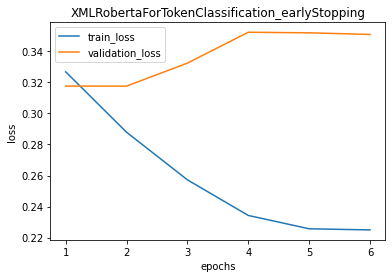

In [41]:
epochs = np.arange(1,epoch+1)
print(epochs)
plt.plot(epochs,loss_train[:-1],label='train_loss')
plt.plot(epochs,loss_test[:-1],label='validation_loss')
plt.xlabel('epochs')
plt.ylabel('loss')
plt.title('XMLRobertaForTokenClassification_earlyStopping')
plt.legend()
plt.show()

[1 2 3 4 5 6]


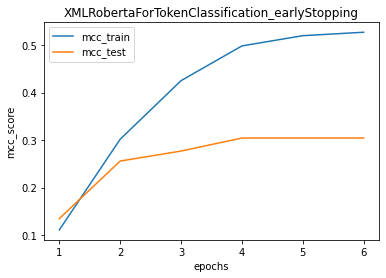

In [42]:
epochs = np.arange(1,epoch+1)
plt.plot(epochs,mcc_score_train[:-1],label='mcc_train')
plt.plot(epochs,mcc_score_test[:-1],label='mcc_test')
plt.xlabel('epochs')
plt.ylabel('mcc_score')
plt.title('XMLRobertaForTokenClassification_earlyStopping')
plt.legend()
plt.show()

In [53]:
from transformers import AutoConfig
config = AutoConfig.from_pretrained('xlm-roberta-base')
config.num_labels

2

In [24]:
boo = None

if 1<2:
    boo = True
print(boo)

True
